In [1]:
import cv2 as cv
import os
import numpy as np
from tqdm import tqdm
from glob import glob
import math

In [2]:
dataset_path = r'../data/PlayingCards'
dataset_train_path = r'../data/PlayingCards/train'
dataset_test_path = r'../data/PlayingCards/test'
dir_path_output: str = '../data/output'

In [3]:
train_path_list: list[str] = list(glob(os.path.join(dataset_train_path, '*.xml')))
test_path_list: list[str] = list(glob(os.path.join(dataset_test_path, '*.xml')))
train_path_list[:2], test_path_list[:2]

(['../data/PlayingCards/train\\cam_image1.xml',
  '../data/PlayingCards/train\\cam_image10.xml'],
 ['../data/PlayingCards/test\\cam_image2.xml',
  '../data/PlayingCards/test\\cam_image4.xml'])

In [6]:
target_path_list = train_path_list[:10]

In [4]:
from xml.etree import ElementTree
from xml.etree.ElementTree import Element


def get_bboxes(file_path: str) -> list[tuple[int, int, int, int]]:
    tree = ElementTree.parse(file_path)
    object_list: list[Element] = tree.findall('object')

    def get_bbox(obj: Element):
        bndbox: Element = obj.find('bndbox')
        x_min = bndbox.findtext('xmin')
        y_min = bndbox.findtext('ymin')
        x_max = bndbox.findtext('xmax')
        y_max = bndbox.findtext('ymax')

        return int(x_min), int(y_min), int(x_max), int(y_max)

    return list(map(get_bbox, object_list))

# Draw labels

In [45]:
color = (0, 0, 255)
thickness = 2
font = cv.FONT_HERSHEY_SIMPLEX
font_size = 0.5

min_h = 0
min_w = 0
for file_path_xml in tqdm(train_path_list):
    base_name = os.path.splitext(file_path_xml)[0]
    file_path_img = f'{base_name}.jpg'
    image_name = os.path.split(file_path_img)[1]

    img: np.ndarray = cv.imread(file_path_img, 1)
    bbox_list: list[tuple[int, int, int, int]] = get_bboxes(file_path_xml)
    for bbox in bbox_list:
        x0, y0, x1, y1 = bbox
        if y1 - y0 > min_h:
            min_h = y1 - y0
        if x1 - x0 > min_w:
            min_w = x1 - x0
    #     cv.rectangle(img, (x0, y0), (x1, y1), color, thickness)
    #
    # cv.imwrite(os.path.join(dir_path_output, image_name), img)
print(min_h, min_w)

100%|██████████| 5/5 [00:00<00:00, 60.24it/s]


# Create positives descriptors

In [14]:
positives_count = 0
with open(os.path.join(dataset_path, 'info.dat'), 'w+') as f:
    for file_path_xml in tqdm(train_path_list):
        base_path = os.path.splitext(file_path_xml)[0]
        file_path_img_source: str = f'{base_path}.jpg'
        relative_file_path = os.path.join('.', 'train', os.path.split(file_path_img_source)[1])

        bbox_list: list[tuple[int, int, int, int]] = []
        for bbox in get_bboxes(file_path_xml):
            x0, y0, x1, y1 = bbox
            if x0 >= x1 or y0 >= y1:
                print(file_path_xml)
            bbox_list.append((x0, y0, x1 - x0, y1 - y0))

        bbox_descriptor: str = '  '.join([' '.join(map(str, cords)) for cords in bbox_list])
        f.write(f'{relative_file_path} {len(bbox_list)} {bbox_descriptor}\n')
        positives_count += len(bbox_list)

100%|██████████| 296/296 [00:01<00:00, 214.31it/s]


In [15]:
positives_count

527

# Copy negatives

In [20]:
min_width = 128
min_height = 128
negative_folder = r'../data/PlayingCards/negatives'
negative_image_path_list: list[str] = []
for file_path_xml in tqdm(train_path_list):
    xmin, ymin, xmax, ymax = math.inf, math.inf, -math.inf, -math.inf
    for bbox in get_bboxes(file_path_xml):
        x0, y0, x1, y1 = bbox
        if x0 < xmin:
            xmin = x0
        if y0 < ymin:
            ymin = y0
        if x1 > xmax:
            xmax = x1
        if y1 > ymax:
            ymax = y1

    base_path = os.path.splitext(file_path_xml)[0]
    sample_id = os.path.split(base_path)[1]
    img = cv.imread(f'{base_path}.jpg')

    if xmin >= min_width and img.shape[0] >= min_height:
        img_left = img[:, :xmin]
        img_left_path = os.path.join(negative_folder, f'{sample_id}_left.jpg')
        cv.imwrite(img_left_path, img_left)
        negative_image_path_list.append(img_left_path)

    if ymin >= min_height and img.shape[1] >= min_width:
        img_top = img[: ymin]
        img_top_path = os.path.join(negative_folder, f'{sample_id}_top.jpg')
        cv.imwrite(img_top_path, img_top)
        negative_image_path_list.append(img_top_path)

    if img.shape[1] - xmax >= min_width and img.shape[0] >= min_height:
        img_right = img[:, xmax:]
        img_right_path = os.path.join(negative_folder, f'{sample_id}_right.jpg')
        cv.imwrite(img_right_path, img_right)
        negative_image_path_list.append(img_right_path)

    if img.shape[0] - ymax >= min_height and img.shape[1] >= min_width:
        img_bottom = img[ymax:]
        img_bottom_path = os.path.join(negative_folder, f'{sample_id}_bottom.jpg')
        cv.imwrite(img_bottom_path, img_bottom)
        negative_image_path_list.append(img_bottom_path)

100%|██████████| 296/296 [00:02<00:00, 142.58it/s]


In [23]:
with open(os.path.join(dataset_path, 'bg.txt'), 'w+') as f:
    for path in negative_image_path_list:
        img_name = os.path.split(path)[1]
        f.write(os.path.join('.', 'negatives', img_name) + '\n')

# Evaluate

In [11]:
cascade = cv.CascadeClassifier()
if not cascade.load(os.path.join(dataset_path, 'classifier2/cascade.xml')):
    print('--(!)Error loading face cascade')

In [12]:
from matplotlib import pyplot as plt


def detect(xml_path: str) -> tuple[np.ndarray, int]:
    test_img_path = f'{os.path.splitext(xml_path)[0]}.jpg'
    test_img = cv.imread(test_img_path)
    factor = 1
    resized = cv.resize(test_img, (test_img.shape[1] // factor, test_img.shape[0] // factor), interpolation=cv.INTER_AREA)
    frame_gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    # frame_gray = cv.equalizeHist(frame_gray)
#42 // factor, 59 // factor
    # maxSize=(314//factor, 351 // factor)
    objects_found = cascade.detectMultiScale(frame_gray, minNeighbors=3, minSize=(42 // factor, 59 // factor), )

    color = (0, 0, 255)
    thickness = 2
    for (x, y, w, h) in objects_found:
        center = (x + w // 2, y + h // 2)
        cv.rectangle(resized, center, (x + w, y + h), color, thickness)

    return resized, len(objects_found)

# for idx, path in enumerate(test_path_list):
#     img_detected, count = detect(path)
#     if count > 0:
#         print(idx)
# plt.imshow(img_detected)
# plt.show()

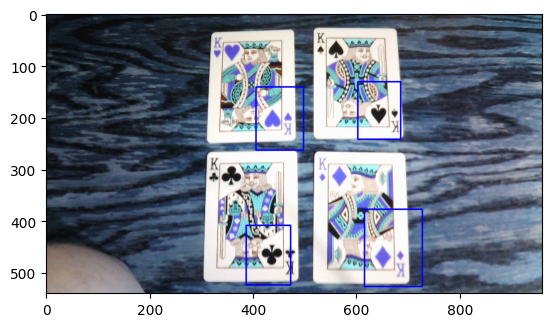

In [13]:
img_detected, count = detect(test_path_list[0])
plt.imshow(img_detected)
plt.show()